In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# --- Setup & Imports ----------------------------------------------------------
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, gc, h5py
import pickle
from scipy import stats
import scipy.io as sio
from scipy.io import loadmat
import pandas as pd
from scipy.stats import pearsonr, linregress
from numpy.lib.format import open_memmap
import matplotlib.pyplot as plt

# Point Python to your src/ folder
sys.path.append(os.path.abspath("../src"))

from preprocessing_hcp import *
from NPI import *
from group_analysis import *


# Import fMRI data (HCP)

Updated data processing

In [6]:
base_dir = os.path.abspath('/content/drive/MyDrive/0.Estudis/3.CBC/Projects/BrainStim_ANN-main/')
n_nodes = 450
nodes_axis=1
time_axis=0

number_of_subjects = 10 # 996 if all

run_files = {
    "REST1_LR": os.path.join(base_dir, "data", "fmri", "Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S3_REST1_LR.mat"),
    "REST1_RL": os.path.join(base_dir, "data", "fmri", "Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S3_REST1_RL.mat"),
    "REST2_LR": os.path.join(base_dir, "data", "fmri", "Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S3_REST2_LR.mat"),
    "REST2_RL": os.path.join(base_dir, "data", "fmri", "Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S3_REST2_RL.mat")
}
run_order = ["REST1_LR", "REST1_RL", "REST2_LR", "REST2_RL"]

dtype = np.float32
out_name = f"HCP_concat_ts_n{number_of_subjects}.npy"
out_path = os.path.join(base_dir, "data", "fmri", out_name)

Find common subjects across runs

In [7]:
def list_subjects(h5path, run_key):
    with h5py.File(h5path, "r") as f:
        return sorted(f["HCP"][run_key].keys(), key=lambda k: int(k.split("_")[-1]))

subject_sets = [set(list_subjects(run_files[k], k)) for k in run_order]
subject_ids = sorted(set.intersection(*subject_sets), key=lambda k: int(k.split("_")[-1]))
n_subj_total = len(subject_ids)
print(f"Found {n_subj_total} subjects present in ALL runs")

#subseting the dataset
subject_ids = subject_ids[:number_of_subjects]
n_subj_modeled = len(subject_ids)
print(f"Number of subjects to be modeled {n_subj_modeled}")

Found 996 subjects present in ALL runs
Number of subjects to be modeled 10


Load each run, preprocess separately

In [19]:
subj_total_len = {}
max_T = 0
for sid in subject_ids:
    total_T = 0
    for run_key in run_order:
        with h5py.File(run_files[run_key], "r") as f:
            ds = f["HCP"][run_key][sid]["ts"]
            plt.figure(figsize=(7, 3))
            plt.imshow(ds, aspect='auto', origin='lower')
            plt.colorbar(label='signal')
            plt.xlabel('nodes')
            plt.ylabel('timepoints')
            plt.title('raster')
            plt.show()
            T_run = ds.shape[time_axis]
            total_T += T_run
    subj_total_len[sid] = total_T
    max_T = max(max_T, total_T)

out = open_memmap(out_path, mode="w+", dtype=dtype,
                  shape=(len(subject_ids), n_nodes, max_T))
out[:] = np.nan  # pad
sid2idx = {sid: i for i, sid in enumerate(subject_ids)}

In [24]:
sid2idx

{'id_100206': 0,
 'id_100307': 1,
 'id_100408': 2,
 'id_101006': 3,
 'id_101107': 4,
 'id_101309': 5,
 'id_101915': 6,
 'id_102008': 7,
 'id_102109': 8,
 'id_102311': 9}

In [25]:
for sid in subject_ids:
    print(f"Processing subject {sid}")
    subj_runs_proc = []
    for run_key in run_order:
        with h5py.File(run_files[run_key], "r") as f:
            ds = f["HCP"][run_key][sid]["ts"]
            arr = ds[()]
        if nodes_axis == 1:
            arr = arr.T          # (N, T)
        arr = arr.astype(dtype, copy=False)
        arr_TN = arr.T           # (T, N)

        arr_proc_TN = bandpass_filter_timeseries(arr_TN)

        subj_runs_proc.append(arr_proc_TN)

        del arr, arr_TN, arr_proc_TN
        gc.collect()

    # concat THIS subject → (T_total_subject, N)
    subj_concat_TN = np.concatenate(subj_runs_proc, axis=0)

    # write to big file in the right row
    i = sid2idx[sid]
    T_subj = subj_concat_TN.shape[0]
    out[i, :, :T_subj] = subj_concat_TN.T  # (N, T_subj)

    del subj_runs_proc, subj_concat_TN
    gc.collect()


Processing subject id_100206
Processing subject id_100307
Processing subject id_100408
Processing subject id_101006
Processing subject id_101107
Processing subject id_101309
Processing subject id_101915
Processing subject id_102008
Processing subject id_102109
Processing subject id_102311


In [26]:
out.shape

(10, 450, 4800)

# Train the model (run from here!)

In [6]:
base_dir = '../'
number_of_subjects = 10 # 10 or 996 if all
out_name = f"HCP_concat_ts_n{number_of_subjects}.npy"
out_path = os.path.join(base_dir, "data", "fmri", out_name)

X = np.load(out_path, mmap_mode="r")   # (S, N, T_max)

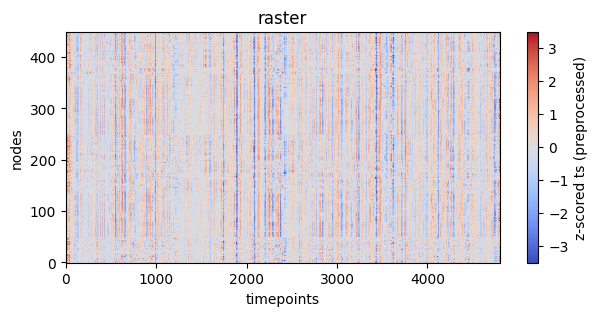

In [18]:
#raster plot after preprocessing
subj = X[9]

plt.figure(figsize=(7, 3))
plt.imshow(subj, aspect='auto', origin='lower',vmin=-3.5,vmax=3.5,cmap='coolwarm')
plt.colorbar(label='z-scored ts (preprocessed)')
plt.xlabel('timepoints')
plt.ylabel('nodes')
plt.title('raster')
plt.show()

In [20]:
subj.shape

(450, 4800)

In [ ]:
#remove the Nans that we added for the concatenation
subjects = []
for i in range(X.shape[0]):
    subj_NT = X[i]                     # (N, T_max)
    # 1) find valid timepoints (non-NaN)
    valid_mask = ~np.isnan(subj_NT[0])
    subj_NT_valid = subj_NT[:, valid_mask]   # (N, T_i)

    subj_TN = subj_NT_valid.T
    subjects.append(subj_TN)

groups = {"HCP": subjects}

print(subjects[0].shape)  # (T_i, N_valid) -- no padding NaNs now

results = train_models_for_groups(
    groups,
    steps=3,
    batch_size=50,
    train_prop=0.9,
    num_epochs=100,
    lr=1e-3,
    l2=5e-5,
    min_windows=50,
    save_dir=os.path.join(base_dir, "models"),
    save_prefix="ANN_subject"
)


(4800, 450)

=== Group: HCP — 10 subjects ===
[OK]  HCP[0] — T=4800, N=450, W=4797 | final train=0.019075, test=0.251830 (500.8s)
[OK]  HCP[1] — T=4800, N=450, W=4797 | final train=0.019681, test=0.270113 (413.4s)
[OK]  HCP[2] — T=4800, N=450, W=4797 | final train=0.019046, test=0.159605 (570.8s)
[OK]  HCP[3] — T=4800, N=450, W=4797 | final train=0.024241, test=0.239092 (438.3s)
[OK]  HCP[4] — T=4800, N=450, W=4797 | final train=0.014491, test=0.137081 (741.3s)
